In [2]:
%matplotlib inline
from preamble import *

In [3]:
import torch
import torch.nn as nn

# Conventions for this notebook

## Jargon
- Unit = neuron
- Model = neural network
- Feature = dimension of input vector
- Hypothesis = output of the model


## Indices
- $j$ = layer label
- $i$ = unit label in a particular layer
- $m$ = number of features (length of input vector)

## Scalars
- $L$ = total number of layers
- $u^j$ = number of units in layer $j$
- $a_i^j$ is the activation unit $i$ in layer $j$

## Vectors and matrices
- $x$: input vector of dimension $(m \times 1)$
- $a^j$: activation vector of layer $j$ of dimension $(u^j \times 1)$
- $\theta^j$: weight matrix from layer $j$ to $j+1$, of dimension $[u^{j+1} \times (u^j + 1)]$, 
<span style='color:Blue'> where the $+1$ accounts for the bias unit </span>



$$
x =
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_m
\end{bmatrix} \ \ ; \ \
\theta^j =
\begin{bmatrix}
\theta_{10} & \dots & \theta_{1(u^j + 1)}\\
\theta_{20} & \ddots\\
\vdots \\
\theta_{(u^{j+1}) 0} & & \theta_{(u^{j+1})(u^j + 1)}\\
\end{bmatrix} 
$$



# Introduction
A neural network is a universal function $f(x) = y$ approximator, i.e. it can predict $y$ for a given $x$.
In this exercise we want our neural network to represent a non-linear function.

# 1. Set the hyperparameters of the artificial neural network (ANN)
A **hyperparameter** is a constant parameter whose value is set before the training process begins, and that is used to control the training process.

## Model hyperparameters
They refer to the model selection task, i.e. the architecture of the NN.
- `n_input`: size of input layer
- `n_hidden`: size of hidden layer
- `n_out`: size of output layer

## Algorithm hyperparameters
They have no influence on the performance of the model but affect the speed and quality of the training.
- `batch_size`: length of the data to be passed to the neural network at a time
- `learning_rate`: controls how much to change the model in response to the estimated error each time the model weights are updated. A value too small can lead to a long training process, and a value too large can lead to an unstable training process. It can be set-up to be adaptive, meaning it changes during training.

In [5]:
n_input, n_hidden, n_out, batch_size, learning_rate = 10, 15, 1, 100, 0.01

<span style='font-family:"Helvetica"; background:yellow; font-size:1.4em' >
 How much do you think each hyperparameter will affect the quality of the model? 
</span>

# 2 - Build your model

[`Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) stands for sequential container, where modules can be added sequentially and are connected in a cascading way. The output for each module is forwarded sequentially to the next.

In [8]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=1, bias=True)
  (3): Sigmoid()
)


You can uncomment and execute the next line to explore the methods of the `model` object you created

In [14]:
# dir(model)

## 2.1 - Understanding the model
Try the `parameters` method (needs to be instantiated).

In [9]:
model.parameters()

<generator object Module.parameters at 0x7ff6f6c5e9e0>

The `parameters` method gives back a generator, which means it needs to be iterated over to give back an output:

In [21]:
for element in model.parameters():
    print(element.shape)

torch.Size([15, 10])
torch.Size([15])
torch.Size([1, 15])
torch.Size([1])


<span style='font-family:"Helvetica"; background:yellow; font-size:1.4em' >
 Without taking into account any bias unit: can you identify the elements of the model by their dimensions?
</span>

- The first element corresponds to the weight matrix $\theta^1$ from layer 1 to layer 2, of dimensions $u^{j+1} \times u^j = u^{2} \times (u^1) = 15 \times 10$
- The second element corresponds to the values of the activation units in layer 2
- The third element corresponds to the weight matrix $\theta^2$ from layer 2 to layer 3, of dimensions $u^{j+1} \times u^j = u^{3} \times (u^2) = 1 \times 15$
- The fourth element is the output of the model

# 3 - Define the loss function
- `torch.nn` provides many different types of [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions). One of the most popular ones in the [Mean Squared Error (MSE)](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) since it can be applied to a wide variety of cases.
- In general cost functions are chosen depending on desirable properties, such as convexity.

In [22]:
loss_function = nn.MSELoss()

# 4 - Define the optimizer
[`torch.optim`](https://pytorch.org/docs/stable/optim.html) provides implementations of various optimization algorithms. The optimizer object will hold the current state and will update the parameters of the model based on computer gradients. It takes as an input an iterable containing the model parameters, that we explored before.

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 5 - Train the model on a loop
The model learns iteratively in a loop of a given number of epochs. Each loop consists of:
- A forward propagation: compute $y$ given the input and current weights and calculate the loss
- A backward propagation: compute the gradient of the loss function (error of the lost at each unit)
- Gradient descent: update model weights

In [6]:
data_x = torch.randn(batch_size, n_input)
data_y = (torch.rand(size=(batch_size, 1)) < 0.5).float()

In [7]:
print(data_x.size())
print(data_y.size())

torch.Size([100, 10])
torch.Size([100, 1])


In [24]:
losses = []
for epoch in range(5000):
    pred_y = model(data_x)
    loss = loss_function(pred_y, data_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

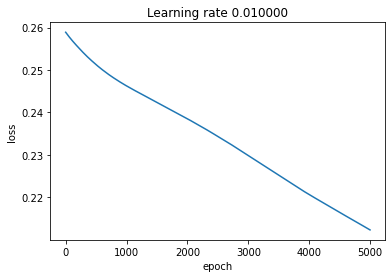

In [25]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()